
# Titanic Survival Prediction — End-to-End ML (Accuracy & Cross-Validation)

**Goal:** Predict passenger survival on the Titanic using structured features, and evaluate models via **accuracy** and **cross-validation**.

This notebook is designed for **Jupyter/Colab** and includes:
1. Data loading & quick sanity checks  
2. Exploratory Data Analysis (EDA) with simple plots  
3. Feature engineering (e.g., passenger title, family size, is-alone)  
4. Preprocessing with `ColumnTransformer` (impute + scale + one-hot)  
5. Train/test split and **cross-validated accuracy**  
6. Baseline models: Logistic Regression, Random Forest, Gradient Boosting  
7. Confusion matrix & interpretation  
8. Save best model and small inference demo

> **Metric focus:** Accuracy (with cross-validation).  
> **Note:** We avoid seaborn per constraints (only `matplotlib`).

## 1. Setup & Imports

In [1]:

import io
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import joblib

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)


Versions -> pandas: 2.3.1 | numpy: 2.3.1


## 2. Load Data & Initial Inspection

In [3]:

data_path = Path("Titanic-Dataset.csv")  # provided upload
df = pd.read_csv(data_path)

print("Shape:", df.shape)
display(df.head(10))

print("\nNull counts per column:")
print(df.isnull().sum())

buf = io.StringIO()
df.info(buf=buf)
print("\nDataFrame.info():")
print(buf.getvalue())


Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C



Null counts per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

DataFrame.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), in


## 3. Define Target & Basic Cleaning

Many Titanic datasets use `Survived` as the target (1 = survived, 0 = died).  
We will:
- Identify the target column (fallback if name differs).
- Keep a subset of relevant columns.
- Create useful engineered features: **Title** (from name), **FamilySize**, **IsAlone**.


In [4]:

# Try to find a survival-like column
possible_targets = [c for c in df.columns if c.lower() in ["survived","survival","target","label","outcome"]]
target_col = possible_targets[0] if possible_targets else "Survived"
if target_col not in df.columns:
    raise ValueError(f"Could not find a target column like 'Survived'. Found: {df.columns.tolist()}")

candidate_cols = ["Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
existing_cols = [c for c in candidate_cols if c in df.columns]

def extract_title(name: str) -> str:
    if not isinstance(name, str):
        return "Unknown"
    if "," in name and "." in name:
        try:
            return name.split(",")[1].split(".")[0].strip()
        except Exception:
            return "Unknown"
    return "Unknown"

df["Title"] = df["Name"].apply(extract_title) if "Name" in df.columns else "Unknown"

if "SibSp" in df.columns and "Parch" in df.columns:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
else:
    df["FamilySize"] = 1
    df["IsAlone"] = 1

feature_cols = []
for c in ["Pclass","Age","SibSp","Parch","Fare","FamilySize","IsAlone"]:
    if c in df.columns:
        feature_cols.append(c)
for c in ["Sex","Embarked","Title"]:
    if c in df.columns and c not in feature_cols:
        feature_cols.append(c)

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Target column:", target_col)
print("Feature columns:", feature_cols)


Target column: Survived
Feature columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex', 'Embarked', 'Title']


## 4. Exploratory Data Analysis (EDA)

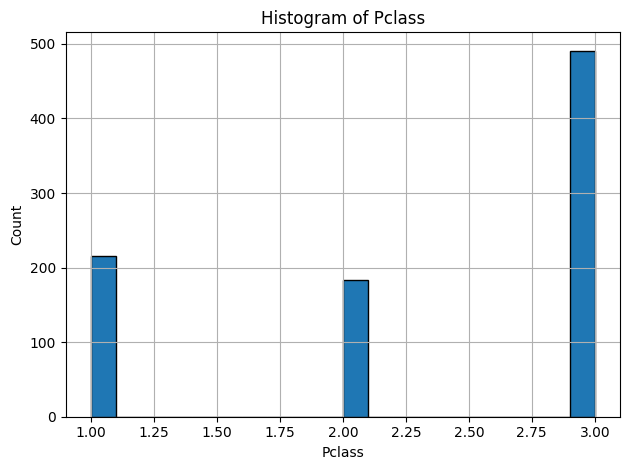

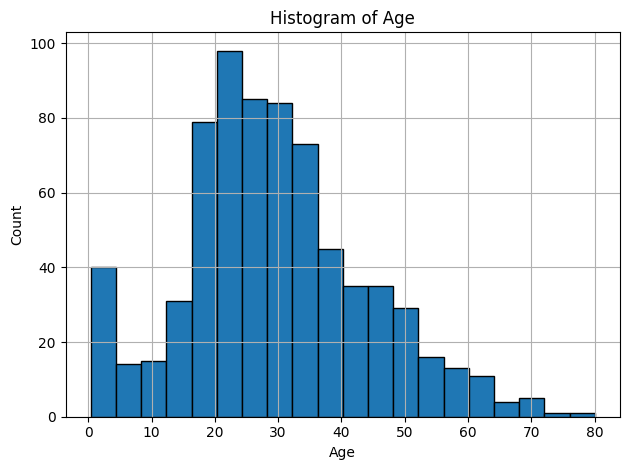

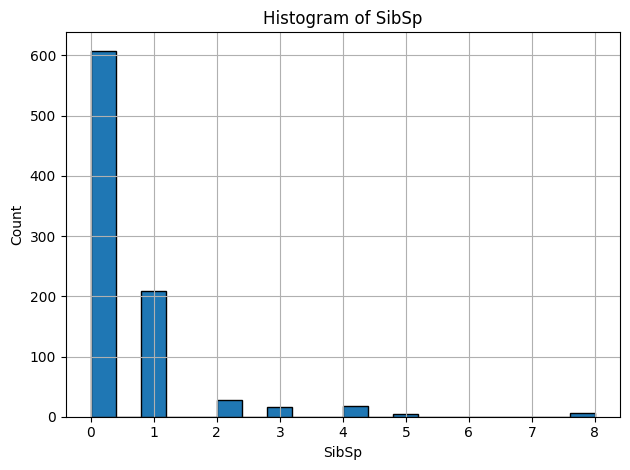

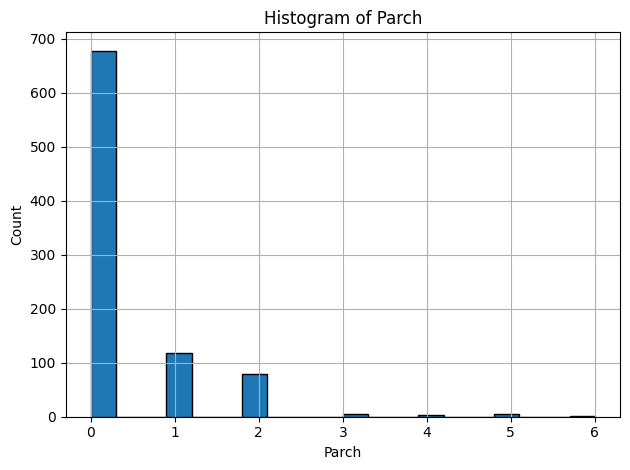

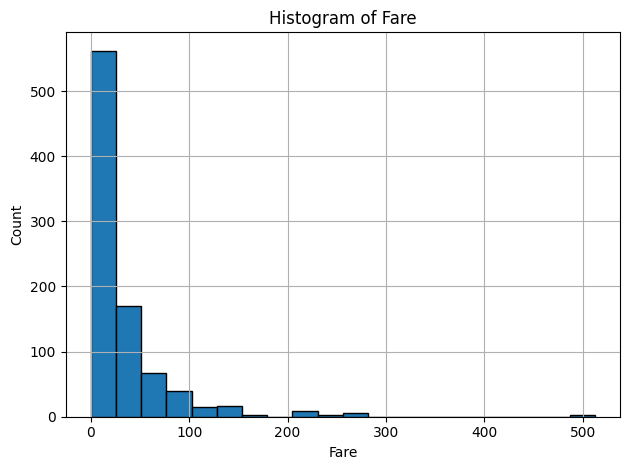

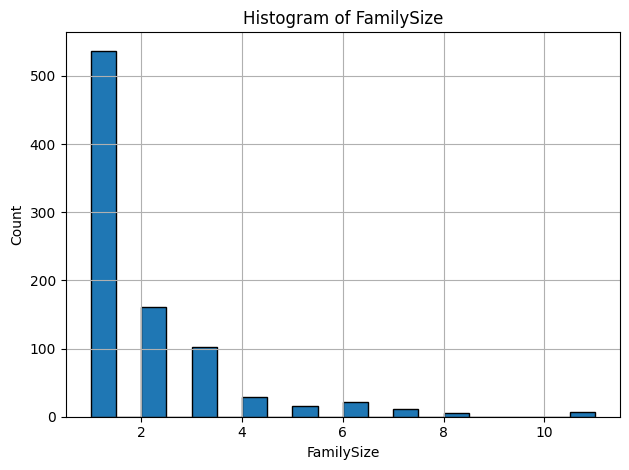

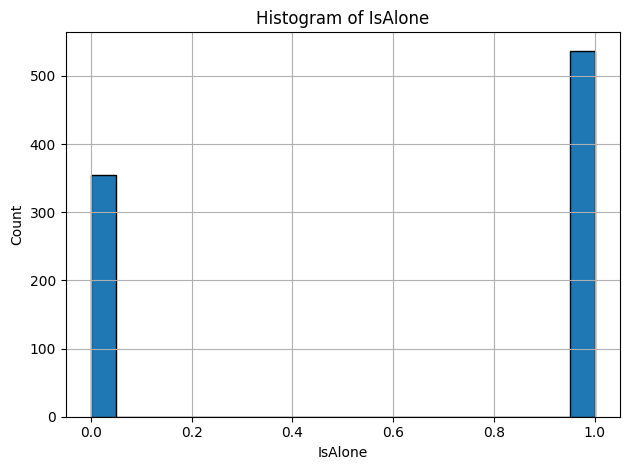

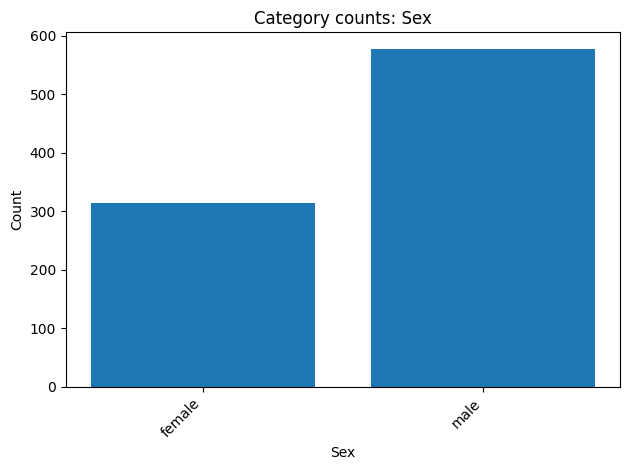

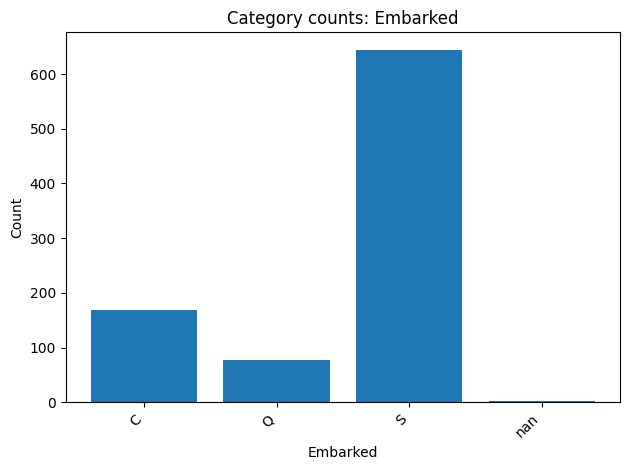

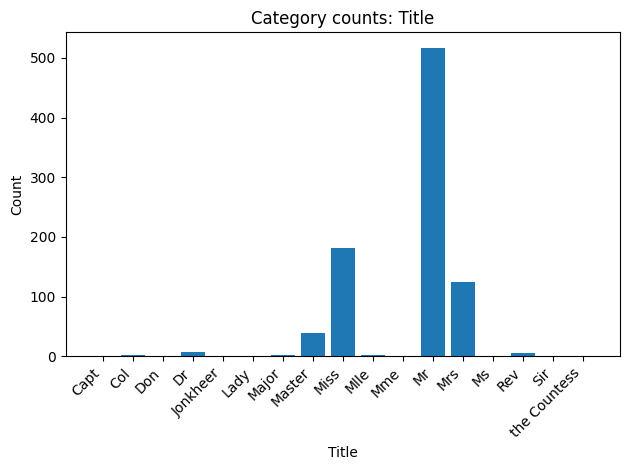

In [5]:

# Histograms for numeric columns
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
for c in num_cols:
    plt.figure()
    X[c].hist(bins=20, edgecolor="black")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.title(f"Histogram of {c}")
    plt.tight_layout()
    plt.show()

# Bar plots for categorical columns
cat_cols = [c for c in X.columns if c not in num_cols]
for c in cat_cols:
    vc = X[c].astype(str).value_counts().sort_index()
    plt.figure()
    plt.bar(vc.index, vc.values)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.title(f"Category counts: {c}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## 5. Train/Test Split

In [6]:

from collections import Counter

class_counts = Counter(y)
can_stratify = (y.nunique() > 1) and all(c >= 2 for c in class_counts.values())
print("Target distribution:", class_counts, "| Stratify =", can_stratify)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if can_stratify else None
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Target distribution: Counter({0: 549, 1: 342}) | Stratify = True
Train shape: (712, 10) | Test shape: (179, 10)


## 6. Preprocessing Pipeline

In [7]:

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical columns: ['Sex', 'Embarked', 'Title']


## 7. Modeling with Accuracy & Cross-Validation

In [8]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

results = []
trained = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    cv_acc = cross_val_score(pipe, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"model": name,
                    "cv_acc_mean": float(np.mean(cv_acc)),
                    "cv_acc_std": float(np.std(cv_acc)),
                    "test_acc": float(acc)})
    trained[name] = (pipe, y_pred)

results_df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(results_df)


,model,cv_acc_mean,cv_acc_std,test_acc
0,LogisticRegression,0.821649,0.021457,0.837989
1,RandomForest,0.796346,0.008920,0.815642
2,GradientBoosting,0.811799,0.027500,0.810056


## 8. Best Model — Confusion Matrix & Report

Best model: LogisticRegression
Test Accuracy: 0.838
CV Accuracy (mean ± std): 0.8216 ± 0.0215

Confusion Matrix:
 [[98 12]
 [17 52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



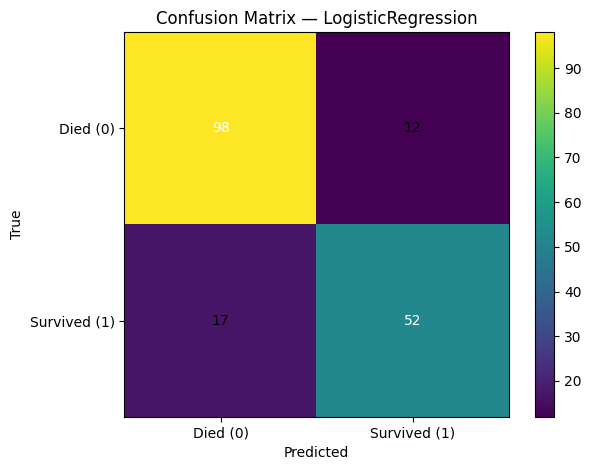

In [9]:

best_row = results_df.iloc[0]
best_name = best_row["model"]
best_pipe, best_pred = trained[best_name]

print("Best model:", best_name)
print("Test Accuracy:", round(best_row["test_acc"], 4))
print("CV Accuracy (mean ± std): {:.4f} ± {:.4f}".format(best_row["cv_acc_mean"], best_row["cv_acc_std"]))

cm = confusion_matrix(y_test, best_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, best_pred))

import numpy as np
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — " + best_name)
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Died (0)","Survived (1)"])
plt.yticks(ticks, ["Died (0)","Survived (1)"])
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 9. Save Best Model & How to Use It

In [13]:
from pathlib import Path
import joblib

# Local save path
model_path = Path("/Users/jivalpatel/Downloads/Volunteer Work/Titanic_Survival_Prediction/titanic_best_model.pkl")

# Make sure directory exists
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the model
joblib.dump(best_pipe, model_path)
print("Saved model to:", model_path)

# Example usage (uncomment to test on a few rows)
# y_new = best_pipe.predict(X_test.head(5))
# print("Sample predictions:", y_new)


Saved model to: /Users/jivalpatel/Downloads/Volunteer Work/Titanic_Survival_Prediction/titanic_best_model.pkl


## 10. Inference Demo — Predict on New/Existing Rows

In [16]:
from pathlib import Path
import joblib

# Local load path
model_path = Path("/Users/jivalpatel/Downloads/Volunteer Work/Titanic_Survival_Prediction/titanic_best_model.pkl")

# Load the saved model
loaded_pipe = joblib.load(model_path)

# Example predictions
example_rows = X_test.head(10).copy()
example_preds = loaded_pipe.predict(example_rows)
example_out = example_rows.copy()
example_out["predicted_survived"] = example_preds

print(example_out)

     Pclass   Age  SibSp  Parch      Fare  FamilySize  IsAlone     Sex  \
565       3  24.0      2      0   24.1500           3        0    male   
160       3  44.0      0      1   16.1000           2        0    male   
553       3  22.0      0      0    7.2250           1        1    male   
860       3  41.0      2      0   14.1083           3        0    male   
241       3   NaN      1      0   15.5000           2        0  female   
559       3  36.0      1      0   17.4000           2        0  female   
387       2  36.0      0      0   13.0000           1        1  female   
536       1  45.0      0      0   26.5500           1        1    male   
698       1  49.0      1      1  110.8833           3        0    male   
99        2  34.0      1      0   26.0000           2        0    male   

    Embarked  Title  predicted_survived  
565        S     Mr                   0  
160        S     Mr                   0  
553        C     Mr                   0  
860        S     